# YOLOv11 Small: License Plate Detector

Train YOLOv11-small to detect license plates directly on full-resolution images (2560x2048 and 1920x1200) without any additional rescaling beyond the model preprocessing.


In [44]:
# YOLOv11 Small: License Plate Detector
# Train YOLOv11-small to detect license plates directly on full-resolution images (2560x2048 and 1920x1200) without any additional rescaling beyond the model preprocessing.

In [45]:
# Imports and paths
import os
import shutil
from pathlib import Path
import ast
import random
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Reproducibility
random.seed(42)
np.random.seed(42)

# Paths
PROJECT_ROOT = Path(r"C:\Users\Tanaphat\Desktop\Coding\ALPR")
DATA_DIR = PROJECT_ROOT / "data" / "8000"
CSV_PATH = DATA_DIR / "8000.csv"
DATASET_DIR = PROJECT_ROOT / "train_lastest" / "yolo_lp_dataset"
YAML_PATH = DATASET_DIR / "plate_dataset.yaml"

print(f"CSV: {CSV_PATH}")
print(f"Dataset out: {DATASET_DIR}")

CSV: C:\Users\Tanaphat\Desktop\Coding\ALPR\data\8000\8000.csv
Dataset out: C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_lp_dataset


In [46]:
# Load CSV and keep valid rows (no rescaling)
df = pd.read_csv(CSV_PATH)
print(f"Total rows: {len(df)}")
df_valid = df[df['is_validate'] == True].copy()
df_valid = df_valid[df_valid['plate_bbox'].notna()].copy()
print(f"Valid rows with plate_bbox: {len(df_valid)}")

def parse_bbox(bbox_str):
    try:
        bbox = ast.literal_eval(bbox_str)
        if isinstance(bbox, list) and len(bbox) > 0:
            return bbox[0]
    except Exception:
        return None
    return None

df_valid['plate_bbox_parsed'] = df_valid['plate_bbox'].apply(parse_bbox)
df_valid['car_bbox_parsed'] = df_valid.get('car_bbox', pd.Series([None]*len(df_valid))).apply(parse_bbox)
df_valid = df_valid[df_valid['plate_bbox_parsed'].notna()].copy()
print(f"After parsing: {len(df_valid)} samples ready")
print(f"With car_bbox: {(df_valid['car_bbox_parsed'].notna()).sum()} / {len(df_valid)}")

Total rows: 8172
Valid rows with plate_bbox: 8172
After parsing: 8172 samples ready
With car_bbox: 8172 / 8172


In [47]:
# Resolve image paths and gather dimensions
def load_image_cv2(img_path: Path):
    img_array = np.fromfile(str(img_path), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {img_path}")
    return img

def check_image(row):
    img_col = 'image_name_gray' if 'image_name_gray' in row else 'image_name'
    img_rel = row[img_col].lstrip('/')
    img_path = DATA_DIR / img_rel
    if not img_path.exists():
        return pd.Series({'exists': False, 'width': None, 'height': None, 'full_path': None})
    try:
        img = load_image_cv2(img_path)
        h, w = img.shape[:2]
        return pd.Series({'exists': True, 'width': w, 'height': h, 'full_path': str(img_path)})
    except Exception:
        return pd.Series({'exists': False, 'width': None, 'height': None, 'full_path': None})

image_info = df_valid.apply(check_image, axis=1)
df_valid = pd.concat([df_valid, image_info], axis=1)
df_valid = df_valid[df_valid['exists'] == True].copy()
print(f"Images found: {len(df_valid)}")
print("Size distribution:")
print(df_valid.groupby(['width', 'height']).size())

Images found: 8172
Size distribution:
width  height
1920   1200        23
2560   2048      8149
dtype: int64


In [48]:
# Train/val/test split and helpers
def convert_to_yolo_format(bbox, img_width, img_height):
    x1, y1, x2, y2 = bbox
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    width = x2 - x1
    height = y2 - y1
    return [x_center / img_width, y_center / img_height, width / img_width, height / img_height]

# Split 70/20/10
train_df, temp_df = train_test_split(df_valid, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.3333, random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Fresh dataset directory
if DATASET_DIR.exists():
    shutil.rmtree(DATASET_DIR)
for split in ['train', 'val', 'test']:
    (DATASET_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
    (DATASET_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)
print(f"Dataset directory ready at {DATASET_DIR}")

Train: 5720, Val: 1634, Test: 818
Dataset directory ready at C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_lp_dataset


In [49]:
# Build YOLO-format dataset (handles plate_bbox relative to car_bbox)
def clamp_bbox(bbox, w, h):
    x1, y1, x2, y2 = bbox
    x1 = max(0, min(x1, w))
    y1 = max(0, min(y1, h))
    x2 = max(0, min(x2, w))
    y2 = max(0, min(y2, h))
    return [x1, y1, x2, y2]

def plate_to_absolute(plate_rel, car_bbox):
    """Convert plate bbox from car-relative to full-image coordinates."""
    if plate_rel is None or car_bbox is None:
        return None
    px1, py1, px2, py2 = plate_rel
    cx1, cy1, _, _ = car_bbox
    return [px1 + cx1, py1 + cy1, px2 + cx1, py2 + cy1]

def process_split(df, split_name):
    print(f"Processing {split_name} ({len(df)} samples)...")
    img_dir = DATASET_DIR / 'images' / split_name
    label_dir = DATASET_DIR / 'labels' / split_name
    success = 0
    errors = 0
    for idx, row in df.iterrows():
        try:
            src_img = Path(row['full_path'])
            dst_img = img_dir / f"{split_name}_{idx}{src_img.suffix}"
            dst_lbl = label_dir / f"{split_name}_{idx}.txt"

            shutil.copy2(src_img, dst_img)

            # plate bbox in CSV is relative to car_bbox; shift to absolute coords
            plate_abs = plate_to_absolute(row['plate_bbox_parsed'], row.get('car_bbox_parsed'))
            if plate_abs is None:
                raise ValueError("Missing car_bbox for relative plate_bbox")

            bbox = clamp_bbox(plate_abs, row['width'], row['height'])
            yolo_bbox = convert_to_yolo_format(bbox, row['width'], row['height'])
            with open(dst_lbl, 'w') as f:
                f.write(f"0 {yolo_bbox[0]:.6f} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f}\n")
            success += 1
        except Exception as e:
            errors += 1
            print(f"  Error {idx}: {e}")
    print(f"✓ {split_name}: {success} written, {errors} errors")
    return success, errors

train_stats = process_split(train_df, 'train')
val_stats = process_split(val_df, 'val')
test_stats = process_split(test_df, 'test')
print(f"Total images: {train_stats[0] + val_stats[0] + test_stats[0]}")

Processing train (5720 samples)...
✓ train: 5720 written, 0 errors
Processing val (1634 samples)...
✓ val: 1634 written, 0 errors
Processing test (818 samples)...
✓ test: 818 written, 0 errors
Total images: 8172


In [50]:
# Write dataset YAML
yaml_content = f"""# License Plate Detection Dataset (full-res, no manual rescaling)
path: {str(DATASET_DIR)}
train: images/train
val: images/val
test: images/test

names:
  0: plate
"""

with open(YAML_PATH, 'w') as f:
    f.write(yaml_content)

print(f"YAML saved to {YAML_PATH}")
print(yaml_content)

YAML saved to C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_lp_dataset\plate_dataset.yaml
# License Plate Detection Dataset (full-res, no manual rescaling)
path: C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_lp_dataset
train: images/train
val: images/val
test: images/test

names:
  0: plate



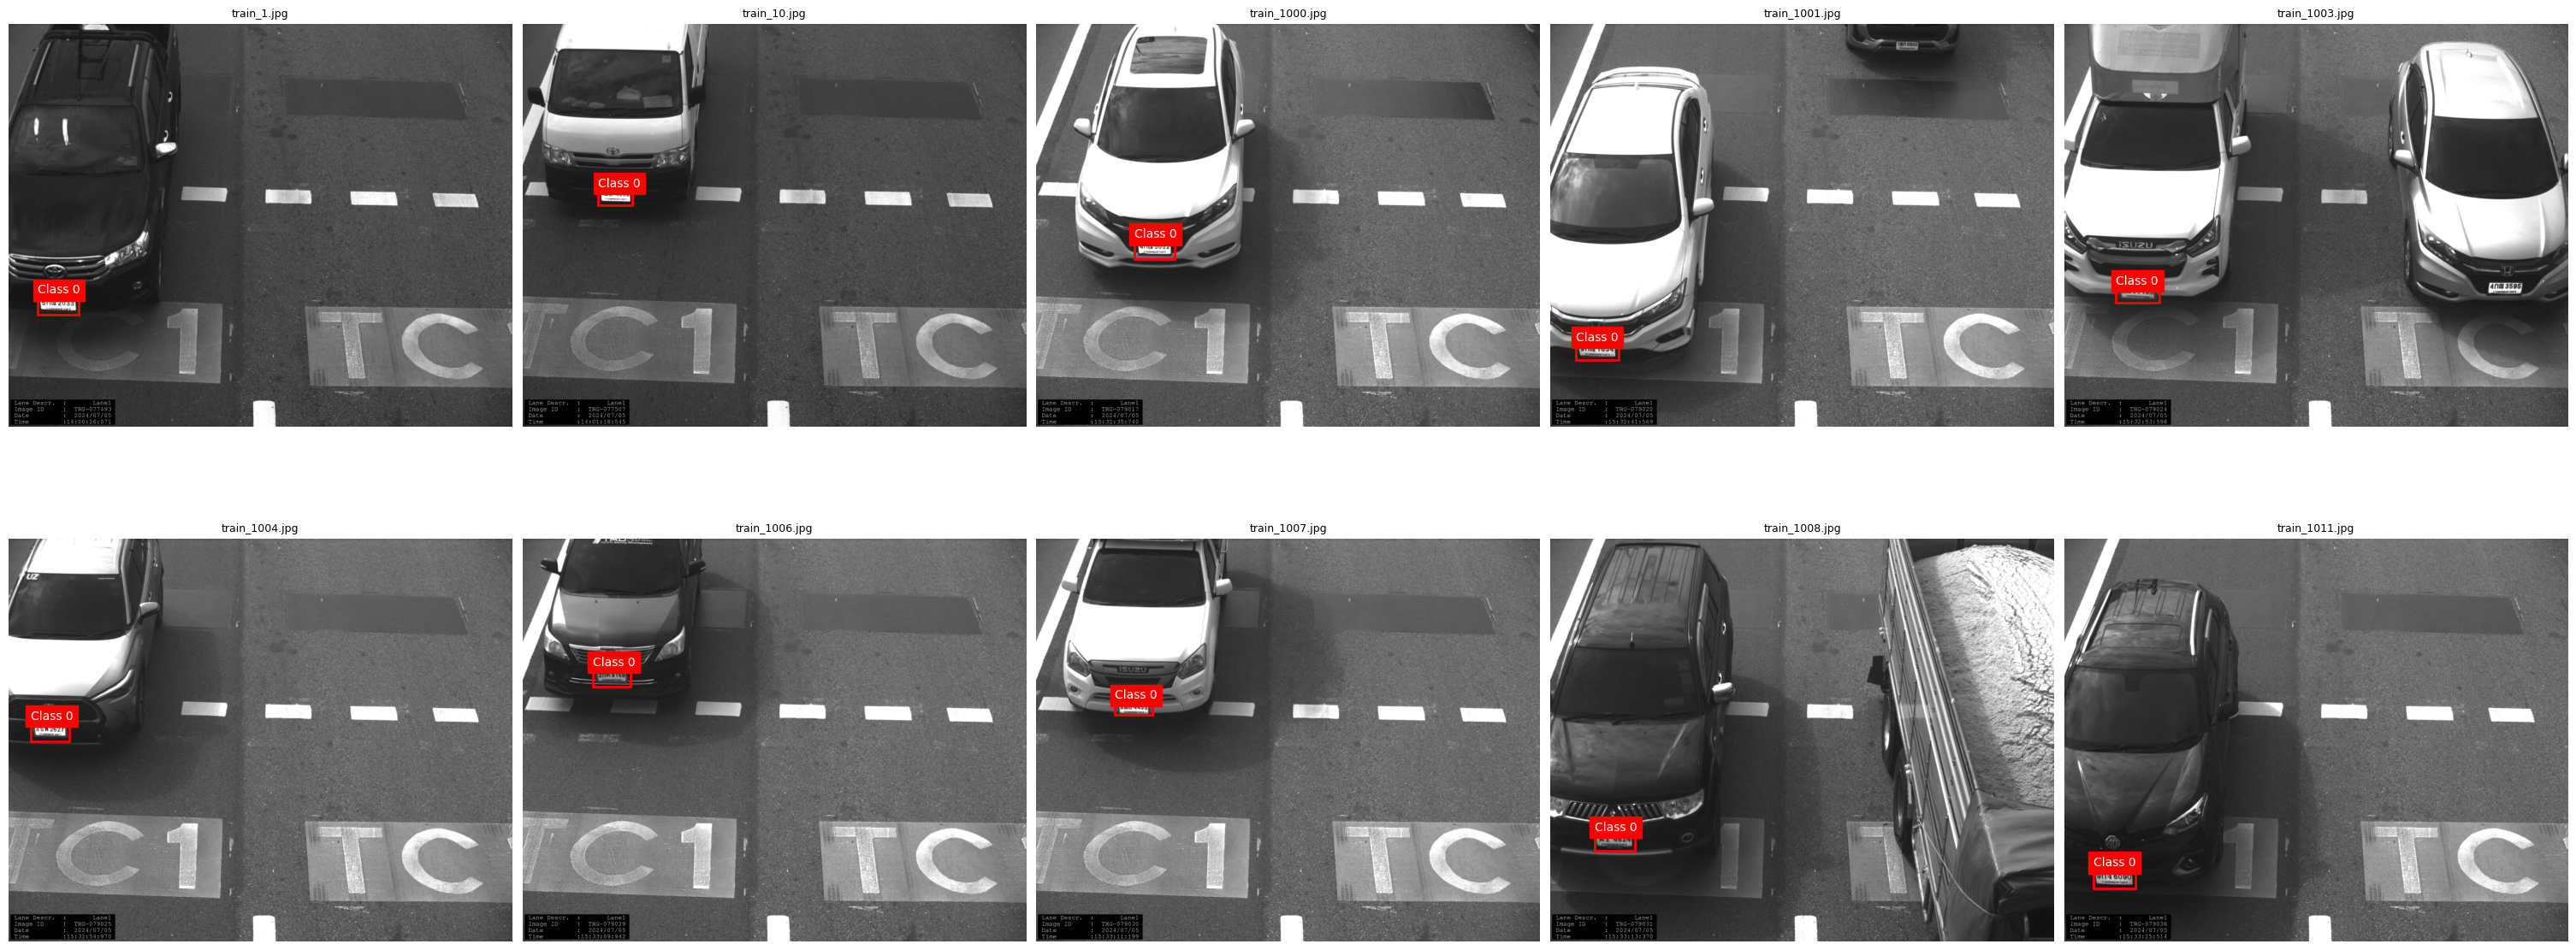

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

def visualize_samples(split='train', num_samples=30, cols=5):
    img_dir = DATASET_DIR / 'images' / split
    label_dir = DATASET_DIR / 'labels' / split
    
    # ตรวจสอบว่ามีโฟลเดอร์อยู่จริงหรือไม่
    if not img_dir.exists():
        print(f"Directory not found: {img_dir}")
        return

    imgs = sorted(list(img_dir.glob('*')))
    if not imgs:
        print(f"No images found in {img_dir}")
        return

    num_samples = min(num_samples, len(imgs))
    cols = max(1, cols)
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6), constrained_layout=True)
    
    # กรณีมีรูปเดียว axes จะไม่ใช่ array ต้องแปลงก่อน
    if num_samples == 1:
        axes = np.array([axes])
    
    flat_axes = np.array(axes).flatten()

    for ax, img_path in zip(flat_axes, imgs[:num_samples]):
        # โหลดรูปภาพ
        img = cv2.imdecode(np.fromfile(str(img_path), dtype=np.uint8), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        ax.imshow(img)
        
        # โหลด Label
        label_path = label_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines() # แก้: อ่านทุกบรรทัด (ทุก object)
                
            for line in lines:
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 5:
                    cls_id = int(parts[0])
                    xc, yc, bw, bh = parts[1], parts[2], parts[3], parts[4]
                    
                    # --- DEBUG SECTION (เช็คค่าตรงนี้) ---
                    # ถ้า xc > 1 แสดงว่าเป็น Pixel Coordinate ไม่ใช่ Normalized
                    # print(f"File: {img_path.name} | Raw: {xc:.2f}, {yc:.2f}, {bw:.2f}, {bh:.2f}") 
                    
                    # คำนวณพิกัด (สูตร YOLO: Center Normalized -> Top-Left Pixel)
                    x1 = (xc - bw/2) * w
                    y1 = (yc - bh/2) * h
                    w_box = bw * w
                    h_box = bh * h
                    
                    # วาดกรอบ
                    rect = patches.Rectangle(
                        (x1, y1), w_box, h_box, 
                        linewidth=2, edgecolor='red', facecolor='none'
                    )
                    ax.add_patch(rect)
                    
                    # ใส่ Text
                    ax.text(x1, y1-5, f"Class {cls_id}", color='white', 
                            fontsize=10, backgroundcolor='red')

        ax.set_xlim(0, w)
        ax.set_ylim(h, 0)
        ax.axis('off')
        ax.set_title(f"{img_path.name}", fontsize=9)

    # ซ่อนแกนที่เหลือ (ถ้ามี)
    for ax in flat_axes[num_samples:]:
        ax.axis('off')
        
    plt.show()

# เรียกใช้งาน
visualize_samples('train', num_samples=10, cols=5)

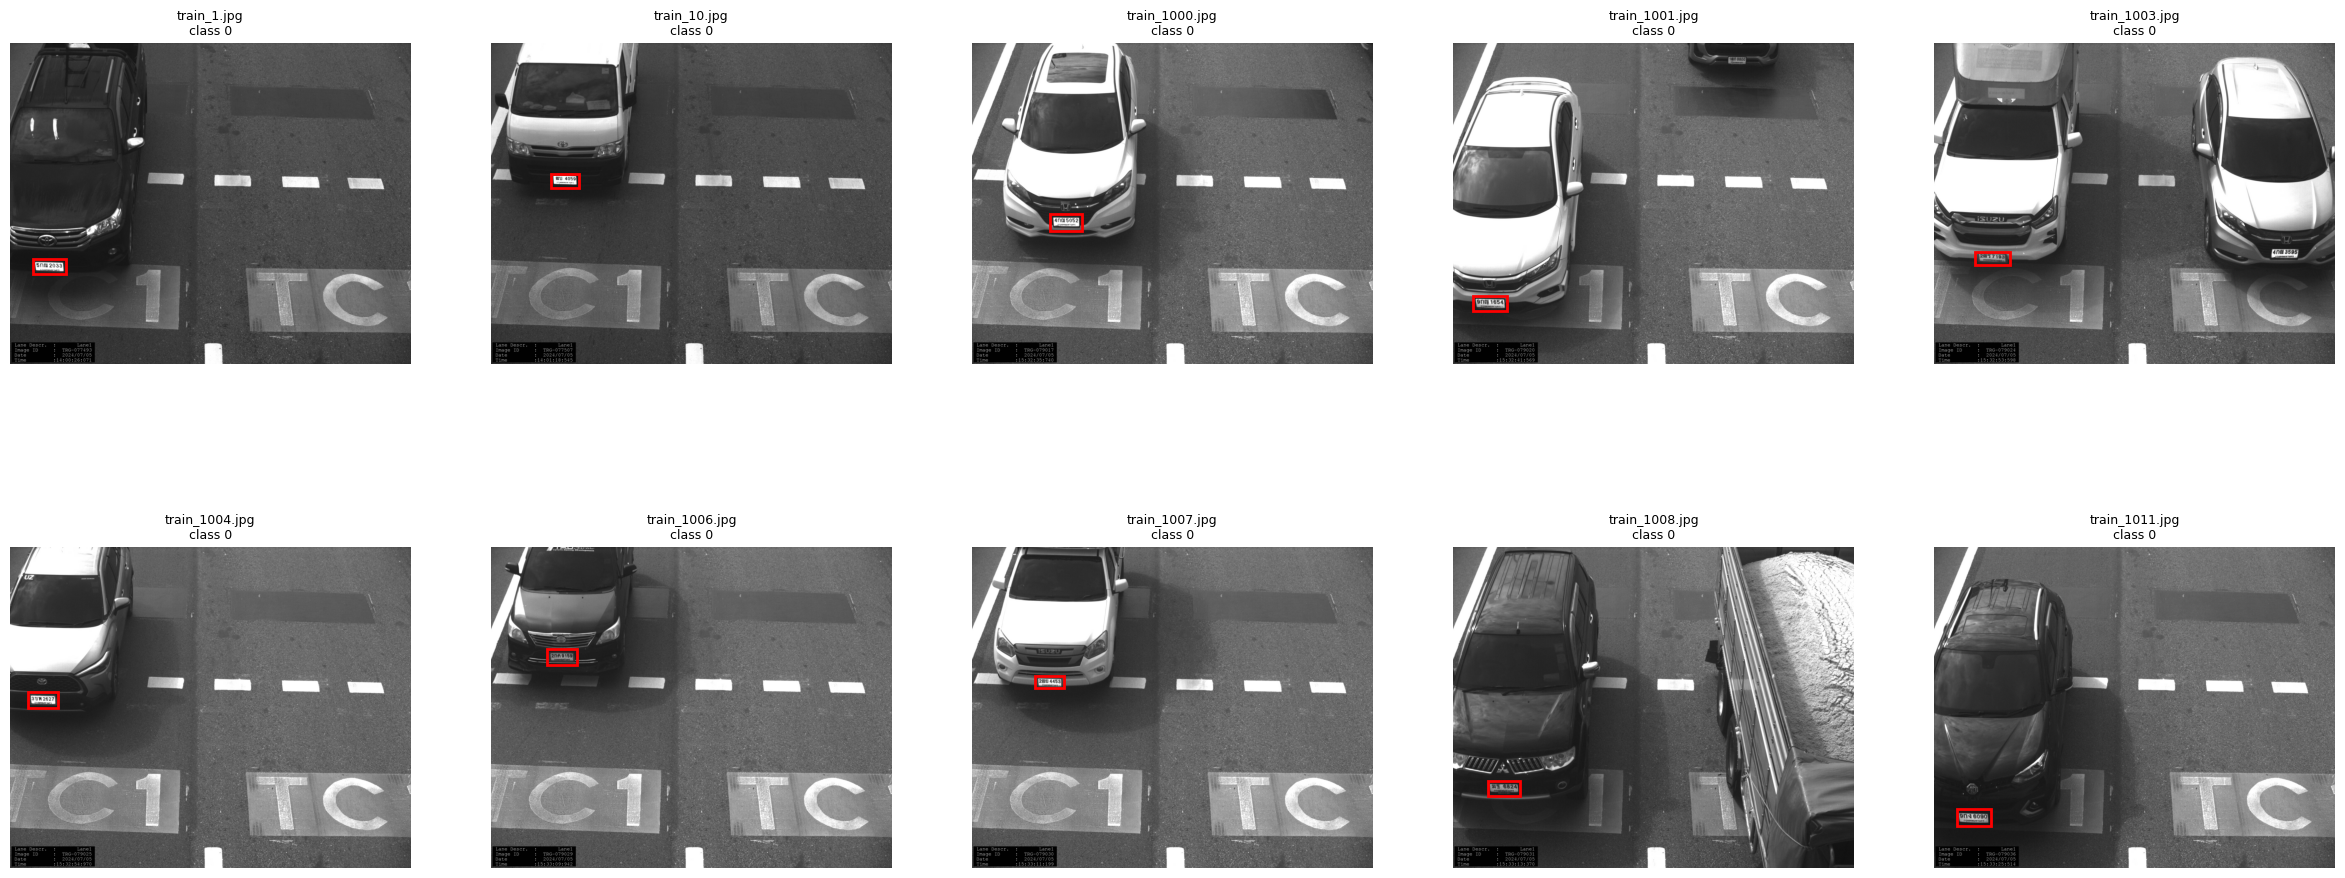

In [52]:
# Quick visualization of many samples (show full image with corrected labels)
def visualize_samples(split='train', num_samples=30, cols=5):
    img_dir = DATASET_DIR / 'images' / split
    label_dir = DATASET_DIR / 'labels' / split
    imgs = sorted(list(img_dir.glob('*')))
    if not imgs:
        print(f"No images found in {img_dir}")
        return
    num_samples = min(num_samples, len(imgs))
    cols = max(1, cols)
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6), constrained_layout=False)
    axes = np.array(axes).reshape(rows, cols)
    flat_axes = axes.flatten()
    for ax, img_path in zip(flat_axes, imgs[:num_samples]):
        img = cv2.imdecode(np.fromfile(str(img_path), dtype=np.uint8), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        label_path = label_dir / f"{img_path.stem}.txt"
        ax.imshow(img)
        if label_path.exists():
            with open(label_path, 'r') as f:
                cls_id, xc, yc, bw, bh = map(float, f.readline().split())
            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            rect = patches.Rectangle((x1, y1), bw*w, bh*h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.set_title(f"{img_path.name}\nclass {int(cls_id)}", fontsize=9)
        ax.set_xlim(0, w)
        ax.set_ylim(h, 0)
        ax.set_aspect('equal')
        ax.axis('off')
    # hide any unused axes
    for ax in flat_axes[num_samples:]:
        ax.axis('off')
    plt.show()

visualize_samples('train', num_samples=10, cols=5)

In [ ]:
# Train YOLOv11 small on full-resolution plates
model = YOLO('yolo11s.pt')
print("Model loaded")

results = model.train(
    data=str(YAML_PATH),
    epochs=80,
    imgsz=1280,
    batch=8,
    name='plate_fullres',
    patience=20,
    save=True,
    device=0,  # change to 'cpu' if needed
    workers=4,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    cos_lr=True,
    augment=True,
    project='runs/detect',
    exist_ok=True,
 )
print(f"Training complete. Artifacts: {results.save_dir}")